# Project 4


Predict given an image of a book whether the page visible is being flipped or not.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Data Transformation

We resize the images to be square (200x200) and convert them to a tensor object, normalising the values to [0,1].

In [7]:
data_transform = transforms.Compose([
    # transforms.RandomResizedCrop(500), make 200x200 # normalise values to [0,1], rescaling
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

## Data Loading

Load the data in and set the batch size to 32.

In [8]:
data_dir = "../data/images/"
train_dataset = datasets.ImageFolder(root=data_dir + "training", transform=data_transform) # make val set
test_dataset = datasets.ImageFolder(root=data_dir + "testing", transform=data_transform)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda")

## Train Function

Define a function to train a given model with a loss function and optimiser. Iterates through all the batches for 1 "epoch" of weight updates.

In [9]:
def train(model, loss_fn, dataloader, optimizer):
    epoch_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        y = y.reshape(-1,1)
        preds = model(X)
        loss = loss_fn(preds, y.float())
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        if batch % 10 == 0:
            print(loss.item())
    return epoch_loss

## Model

The model is composed of one convolutional layer with $5 \times 5$ kernel size and a fully connected layer producing a single logit output.

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Conv2d(3, 6, 5)
        self.fc_layer = nn.Linear(6*196*196, 1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x,1)
        x = self.fc_layer(x)
        return x

model = Model()
model.to(device)

Model(
  (conv_layer): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc_layer): Linear(in_features=230496, out_features=1, bias=True)
)

## Hyperparameters

The loss function is binary cross entropy with logits, giving a loss for a prediction over a binary target after applying a sigmoid transformation $\frac{1}{1 + e^{-x}}$ to the output.

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

0.710604727268219
789.7356567382812
1899.2247314453125
973.585693359375
819.7395629882812
282.3038330078125
731.358154296875
90.19795227050781
801.0152587890625
531.70654296875
442.9598388671875
205.40469360351562
35.26752471923828
52.05826187133789
17.4382381439209
9.333383560180664
8.634506225585938
1.5443077087402344
2.985319137573242
1.7097587585449219
0.3859242796897888
1.6553846597671509
0.46450740098953247
0.0014388062991201878
Finished Training


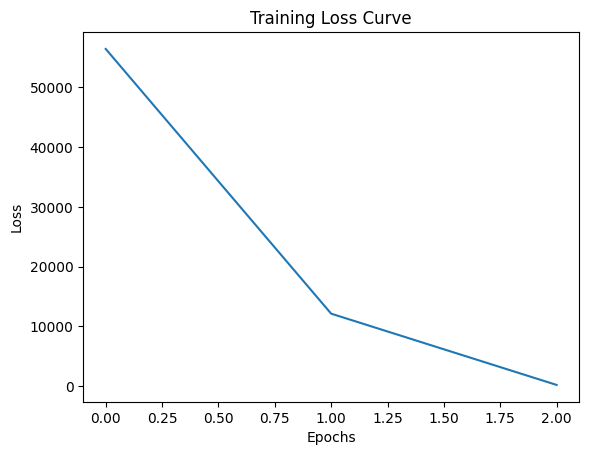

In [12]:
losses = []
for epoch in range(3):
    losses.append(train(model, loss_fn, trainloader, optimizer))
print("Finished Training")
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [13]:
def test(model, dataloader, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            all_preds.extend(preds.cpu())
            all_labels.extend(y.cpu())
    return all_preds, all_labels

In [14]:
def score_to_class(score):
    return 1 if torch.sigmoid(score) > 0.5 else 0

In [15]:
train_output, train_labels = test(model, trainloader, loss_fn)
final_train_preds = [score_to_class(score) for score in train_output]
print("Train Performance")
print(classification_report(train_labels, final_train_preds))

Train Performance
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1162
           1       0.96      0.90      0.93      1230

    accuracy                           0.93      2392
   macro avg       0.93      0.93      0.93      2392
weighted avg       0.93      0.93      0.93      2392



In [20]:
print(confusion_matrix(train_labels, final_train_preds))

[[1116   46]
 [ 117 1113]]


In [16]:
test_output, test_labels = test(model, testloader, loss_fn)
final_test_preds = [score_to_class(score) for score in test_output]
print("Test Performance")
print(classification_report(test_labels, final_test_preds))

Test Performance
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       290
           1       0.94      0.88      0.91       307

    accuracy                           0.91       597
   macro avg       0.91      0.91      0.91       597
weighted avg       0.91      0.91      0.91       597



In [21]:
print(confusion_matrix(test_labels, final_test_preds))

[[273  17]
 [ 36 271]]


# Bonus Task

Predict given a sequence of images whether the sequence contains a flip or not.

In [17]:
sequenceloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

def predictSequence(images):
    with torch.no_grad():
        images = images.to(device)
        scores = model(images)
        preds = [score_to_class(score) for score in scores]
        return 1 if sum(preds) > 1 else 0

In [18]:
all_preds = []
all_labels = []
for X, y in sequenceloader:
    all_preds.append(predictSequence(X))
    all_labels.append(1 if sum(y) > 1 else 0)
print("Performance")
print(classification_report(all_labels, all_preds))      

Performance
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        58
           1       0.94      0.95      0.94        62

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



## Summary

This project involved binary classification on an image dataset. The model type selected to tackle this problem was a Convolutional Neural Network (CNN) due to its ability to use spatial information and its general prevalence on such image classification tasks. We use simplest possible CNN network, a convolutional layer followed by a fully connected layer to produce a single logit of output which is fed through a logistic sigmoid function and thresholded at 0.5 to form a prediction of the class, 0 or 1. Even this simple network has a decent performance, with an accuracy of 0.93 on train and 0.91 on test (fairly balanced dataset). The train and test precisions for not flip are marginally higher than the recalls, while the precisions for flip are lower than their recalls. This may indicate a very slight preference to predict 0. The F1 scores are the same, indicating a well balanced performance.